In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pymysql

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install mysql-connector-python 

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import mysql.connector
import os
import pymysql

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = pymysql.connect(
    host='localhost',
    user='root',
    password='vivek@1mysql',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/bogav/Desktop/Projects/ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import pymysql

db = pymysql.connect(host = "localhost",
                    user = "root",
                    password = "vivek@1mysql",
                    database = "ecommerce")
cur = db.cursor()

### Basic Queries

##### 1. List all unique cities where customers are located.

In [8]:
query = """ select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


##### 2. Count the number of orders placed in 2017. 

In [9]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017  """
cur.execute(query)
data = cur.fetchall()
"Total orders placed in 2017 are", data[0][0]

('Total orders placed in 2017 are', 90202)

##### 3. Find the total sales per category. 

In [25]:
query = """ select upper(products.product_category) category, 
            round(sum(payments.payment_value),2) sales
            from products join order_items
            on products.product_id = order_items.product_id
            join payments
            on payments.order_id = order_items.order_id
            group by category
            """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,4053909.28
1,FURNITURE DECORATION,11441411.13
2,TELEPHONY,3895056.41
3,BED TABLE BATH,13700429.37
4,AUTOMOTIVE,6818354.65
...,...,...
69,CDS MUSIC DVDS,9595.44
70,LA CUISINE,23308.24
71,FASHION CHILDREN'S CLOTHING,6285.36
72,PC GAMER,17395.44


##### 4. Calculate the percentage of orders that were paid in installments. 

In [11]:
query = """ select (sum(case when payment_installments >=1 then 1
            else 0 end))/count(*)*100 from payments
            """
cur.execute(query)
data = cur.fetchall()
"Percentage of orders that were paid in installments is ", data[0][0]

('Percentage of orders that were paid in installments is ', Decimal('99.9981'))

##### 5. Count the number of customers from each state. 

<function matplotlib.pyplot.show(close=None, block=None)>

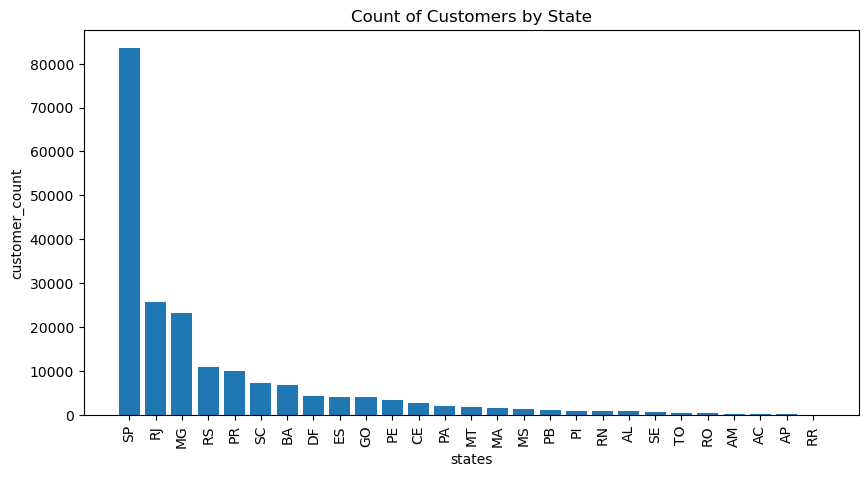

In [12]:
query = """ select customer_state, count(customer_id)
            from customers group by customer_state
            """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["State", "customer_count"] )
df = df.sort_values(by = "customer_count", ascending = False)
plt.figure(figsize = (10,5))
plt.bar(df["State"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by State")
plt.show

### Intermediate Queries 

##### 1. Calculate the number of orders per month in 2018.

<function matplotlib.pyplot.show(close=None, block=None)>

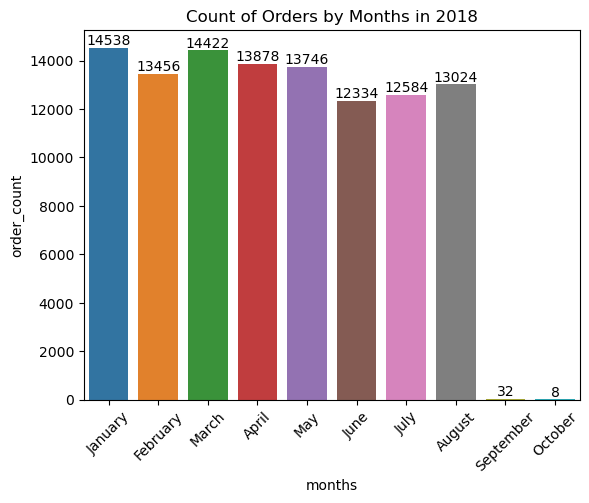

<Figure size 900x300 with 0 Axes>

In [13]:
query = """ select monthname(order_purchase_timestamp) months, 
            count(order_id) order_count
            from orders where year(order_purchase_timestamp) = 2018
            group by months
            """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o  = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
ax = sns.barplot(x = df["months"], y = df["order_count"], data = df, order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])

plt.title("Count of Orders by Months in 2018")
plt.figure(figsize = (9,3))
plt.show

##### 2. Find the average number of products per order, grouped by customer city.

In [14]:
query = """ with count_per_order as 
            (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
            from orders join order_items
            on orders.order_id = order_items.order_id
            group by orders.order_id, orders.customer_id)
            
            select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
            from customers join count_per_order
            on customers.customer_id  = count_per_order.customer_id
            group by customers.customer_city order by average_orders desc
            """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer City", "Average Products/Order"])
df 

,Customer City,Average Products/Order
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
...,...,...
4105,sao mamede,4.00
4106,sambaiba,4.00
4107,japaratuba,4.00
4108,tuiuti,4.00


##### 3. Calculate the percentage of total revenue contributed by each product category.

In [15]:
query = """ select upper(products.product_category) category, 
            round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
            from products join order_items
            on products.product_id = order_items.product_id
            join payments
            on payments.order_id = order_items.order_id
            group by category order by sales_percentage desc;
             """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Percentage distribution"])
df

,Category,Percentage distribution
0,BED TABLE BATH,42.79
1,HEALTH BEAUTY,41.41
2,COMPUTER ACCESSORIES,39.61
3,FURNITURE DECORATION,35.73
4,WATCHES PRESENT,35.71
...,...,...
69,PC GAMER,0.05
70,HOUSE COMFORT 2,0.04
71,CDS MUSIC DVDS,0.03
72,FASHION CHILDREN'S CLOTHING,0.02


##### 4. Identify the correlation between product price and the number of times a product has been purchased.

In [16]:
import numpy as np
query = """ select products.product_category,
            count(order_items.product_id),
            round(avg(order_items.price),2)
            from products join order_items
            on products.product_id = order_items.product_id
            group by products.product_category
             """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Order_count", "Price"])
df

,Category,Order_count,Price
0,HEALTH BEAUTY,38680,130.16
1,sport leisure,34564,114.34
2,Cool Stuff,15184,167.36
3,computer accessories,31308,116.51
4,Watches present,23964,201.14
...,...,...,...
69,flowers,132,33.64
70,Kitchen portable and food coach,60,264.57
71,CITTE AND UPHACK FURNITURE,152,114.95
72,House Comfort 2,120,25.34


In [17]:
arr1 = df["Order_count"]
arr2 = df["Price"]
a = np.corrcoef([arr1,arr2])
print("The correlation betwewen price and number of times a product has been puchased is", a[0][-1])

The correlation betwewen price and number of times a product has been puchased is -0.10631514167157562


##### 5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [18]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
            (select order_items.seller_id, sum(payments.payment_value) 
            revenue from order_items join payments
            on order_items.order_id = payments.order_id
            group by order_items.seller_id) as a
             """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller_id", "Revenue", "Rank"])
df

,Seller_id,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,2.028668e+06,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1.232888e+06,2
2,4a3ca9315b744ce9f8e9374361493884,1.204981e+06,3
3,1f50f920176fa81dab994f9023523100,1.161014e+06,4
4,53243585a1d6dc2643021fd1853d8905,1.139612e+06,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,7.684000e+01,3082
3091,702835e4b785b67a084280efca355756,7.424000e+01,3083
3092,4965a7002cca77301c82d3f91b82e1a9,6.544000e+01,3084
3093,77128dec4bec4878c37ab7d6169d6f26,6.088000e+01,3085


### Advanced Queries


##### 1. Calculate the moving average of order values for each customer over their order history.

In [19]:
query = """ select customer_id, order_purchase_timestamp, payment,
            avg(payment) over(partition by customer_id order by order_purchase_timestamp
            rows between 2 preceding and current row) as mov_avg
            from
            (select orders.customer_id, orders.order_purchase_timestamp,
            payments.payment_value as payment from payments
            join orders
            on payments.order_id = orders.order_id) as a
             """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer_id", "Order_Purchase_Timestamp", "Payment", "Mov_avg"])
df

,Customer_id,Order_Purchase_Timestamp,Payment,Mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


##### 2. Calculate the cumulative sales per month for each year.

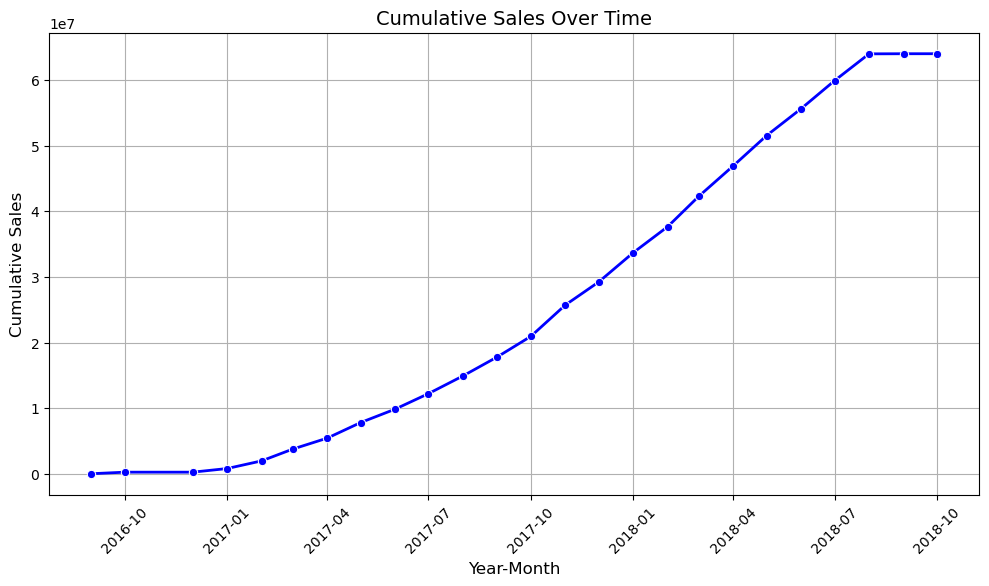

In [20]:
query = """ select years, months, payment, sum(payment)
            over(order by years, months) cumulative_sales from
            (select year(orders.order_purchase_timestamp) as years,
            month(orders.order_purchase_timestamp) as months,
            round(sum(payments.payment_value),2) as payment from orders join payments
            on orders.order_id = payments.order_id
            group by years, months order by years, months) as a
             """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "Months", "Payment", "Cumulative_sales"])

df['Date'] = pd.to_datetime(df['Years'].astype(str) + '-' + df['Months'].astype(str), format='%Y-%m')
df = df.sort_values(by='Date')

plt.figure(figsize=(12, 6))
sns.lineplot(x=df['Date'], y=df['Cumulative_sales'], marker='o', linewidth=2, color='b')
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Cumulative Sales", fontsize=12)
plt.title("Cumulative Sales Over Time", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##### 3. Calculate the year-over-year growth rate of total sales.

In [21]:
query = """ with a as(select year(orders.order_purchase_timestamp) as years,
            round(sum(payments.payment_value),2) as payment from orders join payments
            on orders.order_id = payments.order_id
            group by years order by years)
            
            select years, ((payment - lag(payment, 1) over(order by years))/ 
            lag(payment, 1) over(order by years))*100 from a
            """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "YoY % Growth"])
df

,Years,YoY % Growth
0,2016,NaN
1,2017,12112.703757
2,2018,20.000924


##### 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [22]:
query = """ with a as (select customers.customer_id,
            min(orders.order_purchase_timestamp) first_order
            from customers join orders
            on customers.customer_id = orders.customer_id
            group by customers.customer_id),
            
            b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
            from a join orders
            on orders.customer_id = a.customer_id
            and orders.order_purchase_timestamp > first_order
            and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
            group by a.customer_id)
            
            select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
            from a left join b
            on a.customer_id = b.customer_id
            
            """
cur.execute(query)
data = cur.fetchall()
"The retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase is", data[0][0]

('The retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase is',
 None)

##### 5. Identify the top 3 customers who spent the most money in each year.

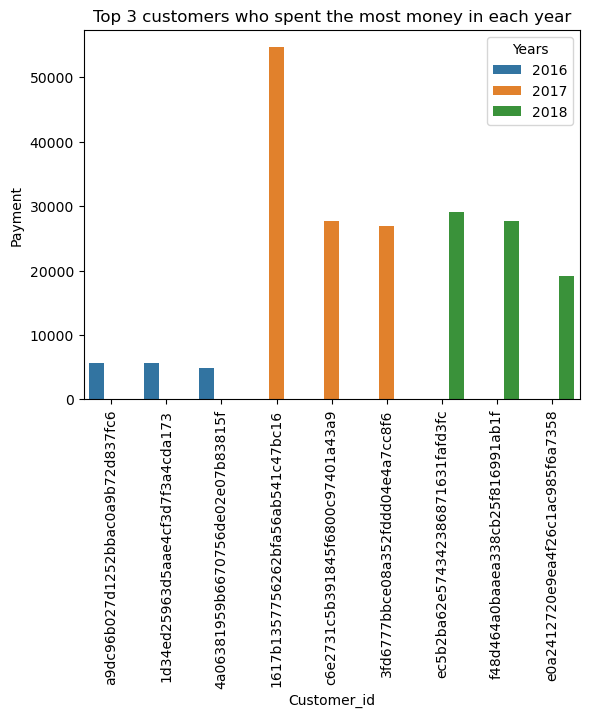

In [28]:
query = """ select years, customer_id, payment, d_rank from
            (select year(orders.order_purchase_timestamp) years, orders.customer_id,
            sum(payments.payment_value) payment, 
            dense_rank() over(partition by year(orders.order_purchase_timestamp)
            order by sum(payments.payment_value) desc) d_rank
            from orders join payments
            on payments.order_id = orders.order_id
            group by year(orders.order_purchase_timestamp), orders.customer_id) as a
            where d_rank <= 3
            """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "Customer_id", "Payment", "D_rank"])
sns.barplot(x = "Customer_id", y = "Payment", data = df, hue = "Years")
plt.xticks(rotation = 90)
plt.title("Top 3 customers who spent the most money in each year")
plt.show()